In [1]:
import sys, os, pickle
sys.path.append('/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import *
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 10
macro_configs = config_generator(lr=[0.0001, 0.0003, 0.001, 0.003],
                                 sg_lr=[0.0001, 0.0003, 0.001, 0.003])
micro_configs = tuple(product(macro_configs, list(range(n_seeds))))

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [2]:
task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
#n_bit (int): The number of independent task dimensions, meaning 3 dimensions.
#p_flip (float): The probability of an input being nonzero, meaning most inputs are 0.
N_train = 200000
N_test = 2000
checkpoint_interval = None
sigma = 0

data = task.gen_data(N_train, N_test)

#n_in = np.maximum(n_bit, 2) = n_out
#3 dimensions
n_in = task.n_in
n_hidden = 32
n_out = task.n_out

#Initialize weights and biases
Wz_in = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
Wr_in = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
Wh_in = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
Wz_rec = np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
Wr_rec = np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
Wh_rec = np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

bz_rec = np.zeros(n_hidden)
br_rec = np.zeros(n_hidden)
bh_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

#alpha: to what extent new gradient will be used.
alpha = 1
#sigma (float): Specifies standard deviation of white noise.
sigma = 0

rnn = GRU(Wz_in,Wr_in,Wh_in, Wz_rec,Wr_rec,Wh_rec, W_out, bz_rec, br_rec, bh_rec, b_out,
          activation=tanh,
          alpha=alpha,
          output=identity,
          loss=mean_squared_error)

#activation: tanh
#relu less stable, less lr for stablization
#learn_alg = Efficient_BPTT(rnn, T_truncation=6)
#learn_alg = DNI(rnn, sg_optimizer)
#learn_alg = KF_RTRL(rnn, L2_reg=0.0001, L1_reg=0.0001)
learn_alg = RFLO(rnn, alpha=alpha, L2_reg=0.0001, L1_reg=0.0001)

#mu= to what extent old gradient will be used.
optimizer = SGD_Momentum(lr=0.01, mu=0.6)
#optimizer = Stochastic_Gradient_Descent(lr=params['sg_lr'])


monitors = []

sim = Simulation(rnn)
sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
        sigma=sigma,
        monitors=monitors,
        verbose=True,
        report_accuracy=False,
        report_loss=True,
        checkpoint_interval=checkpoint_interval)


Progress: 10.0% complete 
Time Elapsed: 10.0s 
Test loss: 0.1251892183663569 

Progress: 20.0% complete 
Time Elapsed: 19.9s 
Test loss: 0.010240048533705963 

Progress: 30.0% complete 
Time Elapsed: 29.9s 
Test loss: 0.005401056383479765 

Progress: 40.0% complete 
Time Elapsed: 40.1s 
Test loss: 0.004997236781716699 

Progress: 50.0% complete 
Time Elapsed: 50.1s 
Test loss: 0.00447325858266085 

Progress: 60.0% complete 
Time Elapsed: 60.3s 
Test loss: 0.0057571237030403614 

Progress: 70.0% complete 
Time Elapsed: 70.2s 
Test loss: 0.004693653635567821 

Progress: 80.0% complete 
Time Elapsed: 80.7s 
Test loss: 0.004834102745553158 

Progress: 90.0% complete 
Time Elapsed: 90.8s 
Test loss: 0.029623991897293207 



In [3]:
test_sim = Simulation(rnn)
test_sim.run(data, mode='test', monitors=['rnn.y_hat','rnn.loss_'], verbose=False)
processed_data = test_sim.mons['rnn.loss_']
#test_sim.mos: a dictionary of monitors
#test_sim.mons['rnn.loss_']: a numpy ndarray
print(np.mean(processed_data))
acc = classification_accuracy(data, test_sim.mons['rnn.y_hat'])
print(acc)

0.03637268619002765
0.514


3


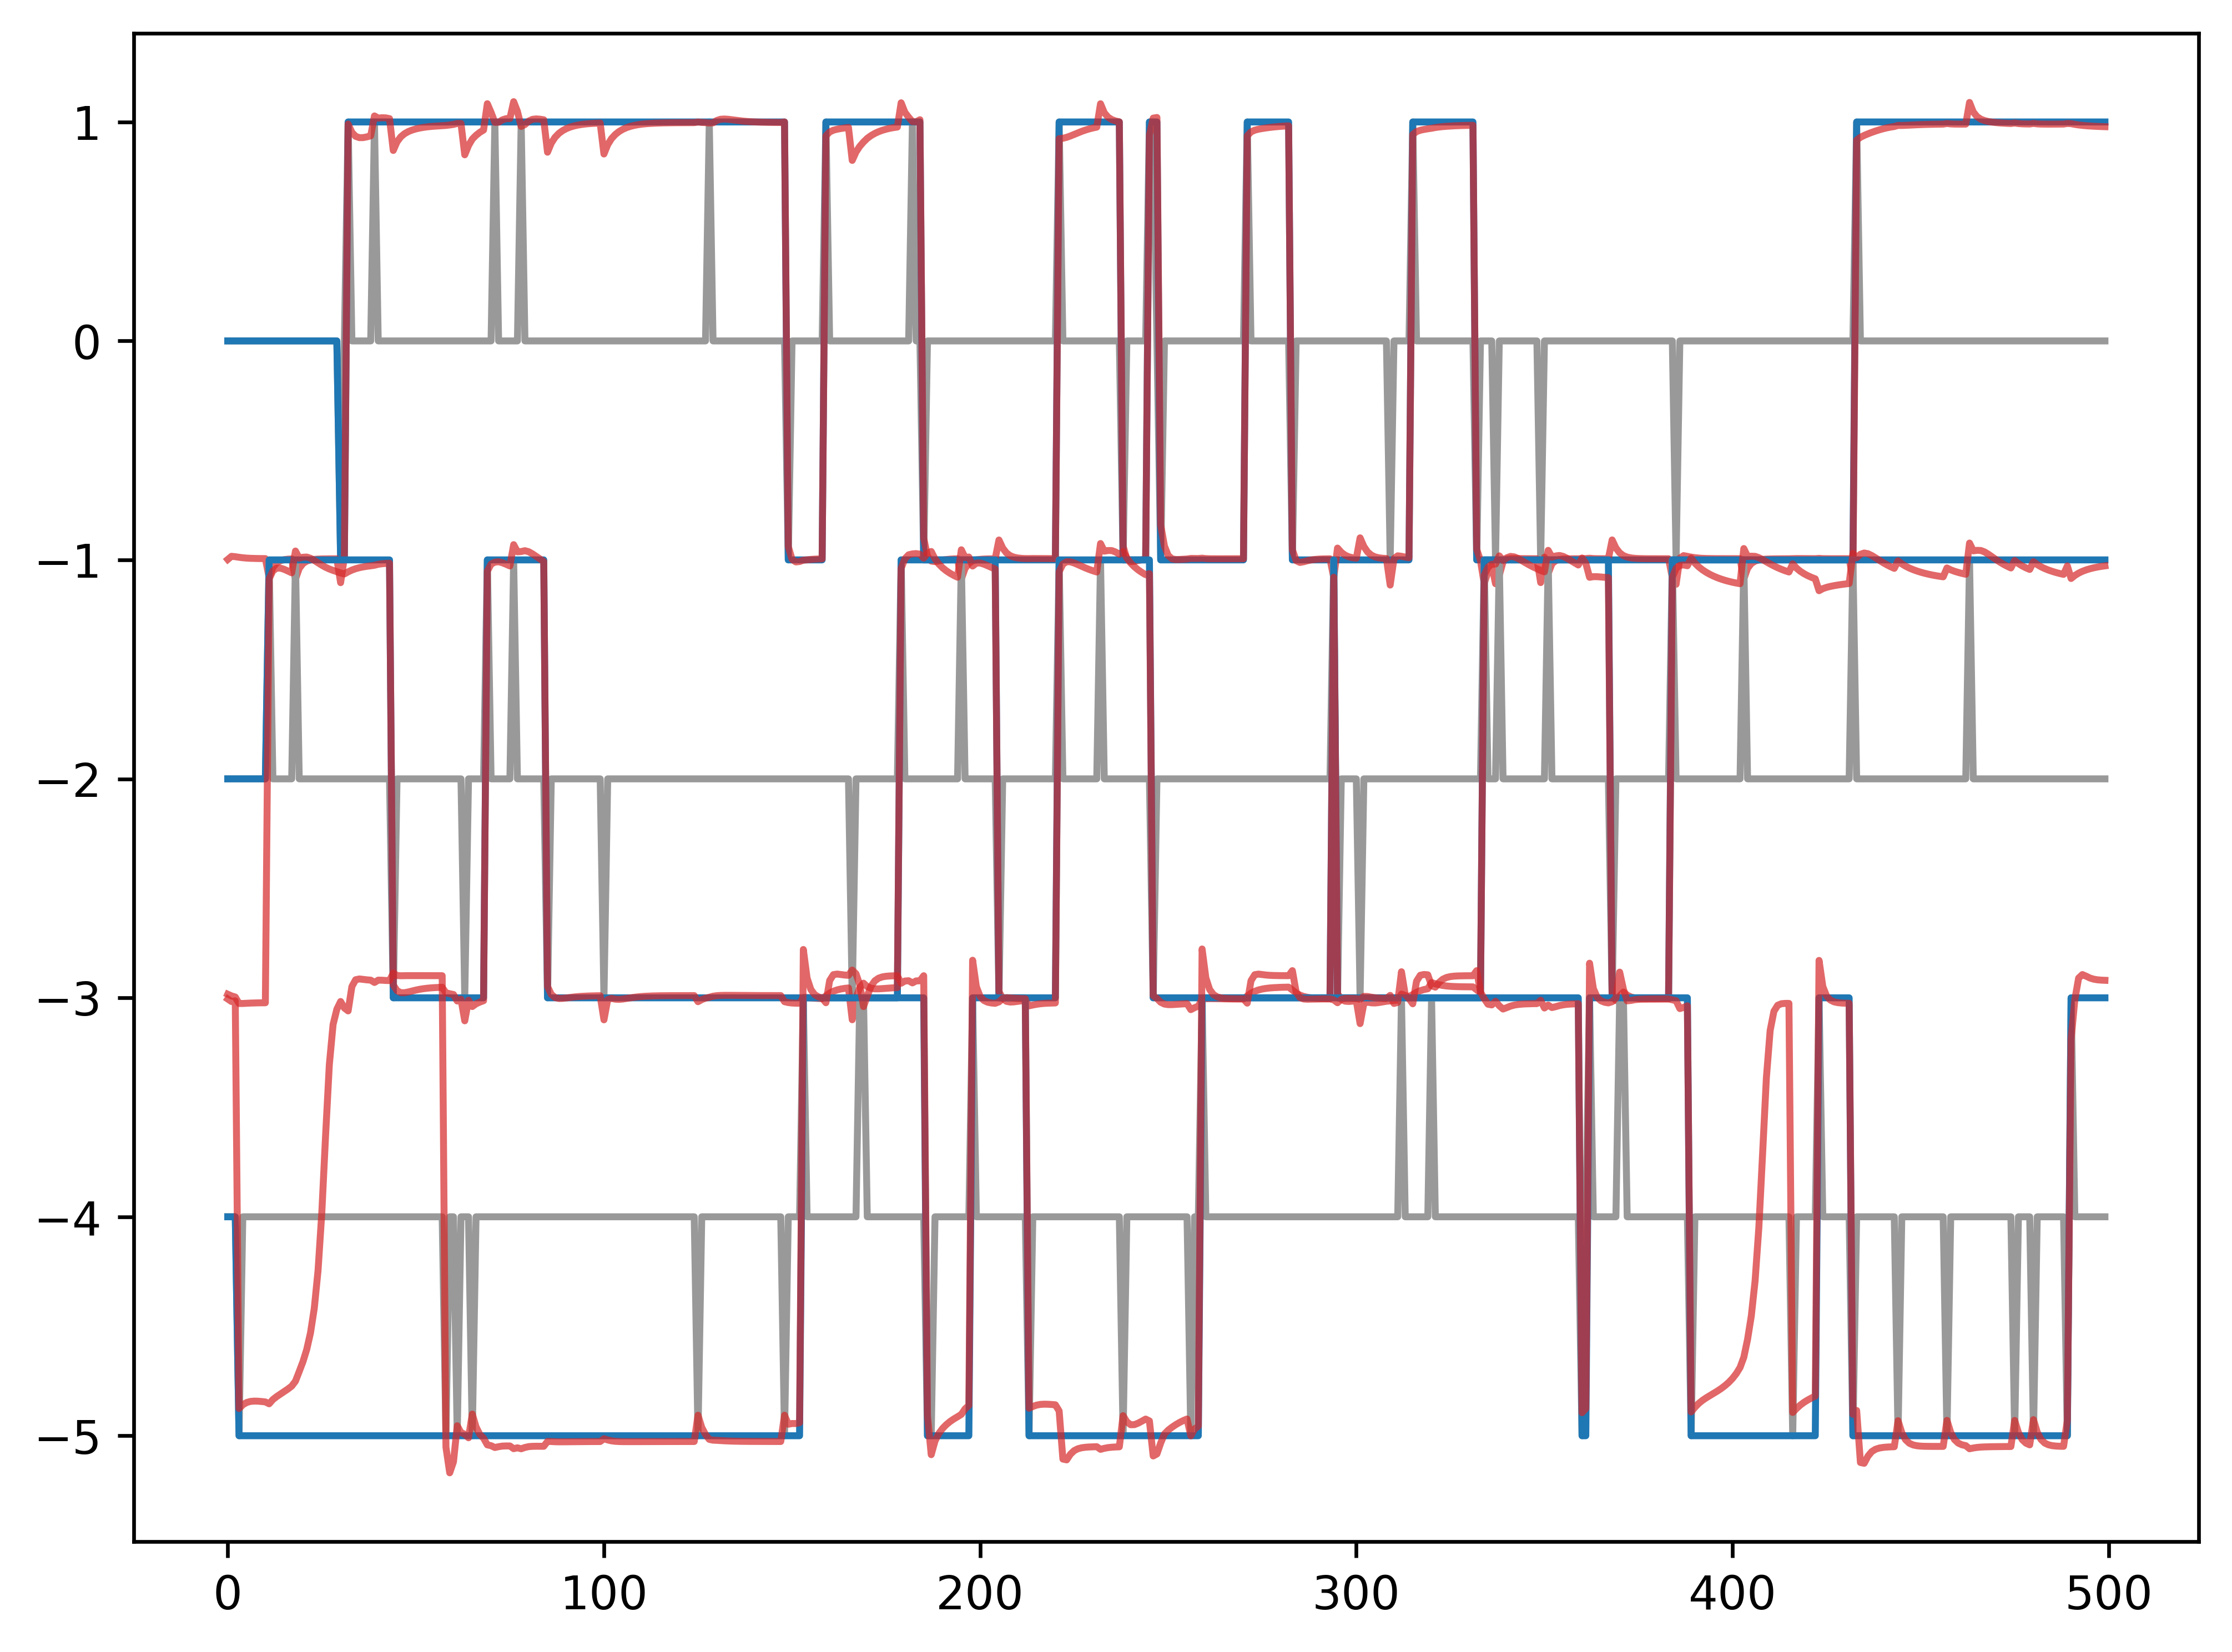

In [5]:
rnn = test_sim.rnn
print(rnn.n_out)
plt.figure(figsize=(8, 6), dpi=600)
for i in range(rnn.n_out):
    plt.plot(data['test']['X'][:500, i] - i * 2, (str(0.6)))
    plt.plot(data['test']['Y'][:500, i] - i * 2, 'C0')
    plt.plot(test_sim.mons['rnn.y_hat'][:500, i] - i * 2, 'C3', alpha=0.7)

In [36]:
task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
N_train = 200000
N_test = 2000
checkpoint_interval = None
sigma = 0

data = task.gen_data(N_train, N_test)

n_in = task.n_in
n_hidden = 32
n_out = task.n_out
W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
W_rec = np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

b_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

alpha = 1
sigma = 0

rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
          activation=relu,
          alpha=alpha,
          output=identity,
          loss=mean_squared_error)

learn_alg = Efficient_BPTT(rnn, T_truncation=6)
#sg_optimizer = Stochastic_Gradient_Descent(lr=params['sg_lr'])
#learn_alg = DNI(rnn, sg_optimizer)
#learn_alg = KF_RTRL(rnn, L2_reg=0.0001, L1_reg=0.0001)
#learn_alg = RFLO(rnn, alpha=alpha, L2_reg=0.0001, L1_reg=0.0001)
optimizer = SGD_Momentum(lr=0.001, mu=0.6)

monitors = []

sim = Simulation(rnn)
sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
        sigma=sigma,
        monitors=monitors,
        verbose=True,
        report_accuracy=False,
        report_loss=True,
        checkpoint_interval=checkpoint_interval)

Progress: 10.0% complete 
Time Elapsed: 3.9s 
Test loss: 0.5013751289814996 

Progress: 20.0% complete 
Time Elapsed: 7.9s 
Test loss: 0.532816098562405 

Progress: 30.0% complete 
Time Elapsed: 11.9s 
Test loss: 0.46677980879575043 

Progress: 40.0% complete 
Time Elapsed: 15.7s 
Test loss: 0.058061649005912784 

Progress: 50.0% complete 
Time Elapsed: 19.5s 
Test loss: 0.051268715501528304 

Progress: 60.0% complete 
Time Elapsed: 23.3s 
Test loss: 0.3747967299855161 

Progress: 70.0% complete 
Time Elapsed: 27.2s 
Test loss: 0.013778277611304816 

Progress: 80.0% complete 
Time Elapsed: 31.1s 
Test loss: 0.07980429172754157 

Progress: 90.0% complete 
Time Elapsed: 34.9s 
Test loss: 0.009655362571627073 



In [37]:
test_sim = Simulation(rnn)
test_sim.run(data, mode='test', monitors=['rnn.y_hat','rnn.loss_'], verbose=False)
processed_data = test_sim.mons['rnn.loss_']
#test_sim.mos: a dictionary of monitors
#test_sim.mons['rnn.loss_']: a numpy ndarray
print(np.mean(processed_data))
acc = classification_accuracy(data, test_sim.mons['rnn.y_hat'])
print(acc)

0.03812345815256378
0.5835


3


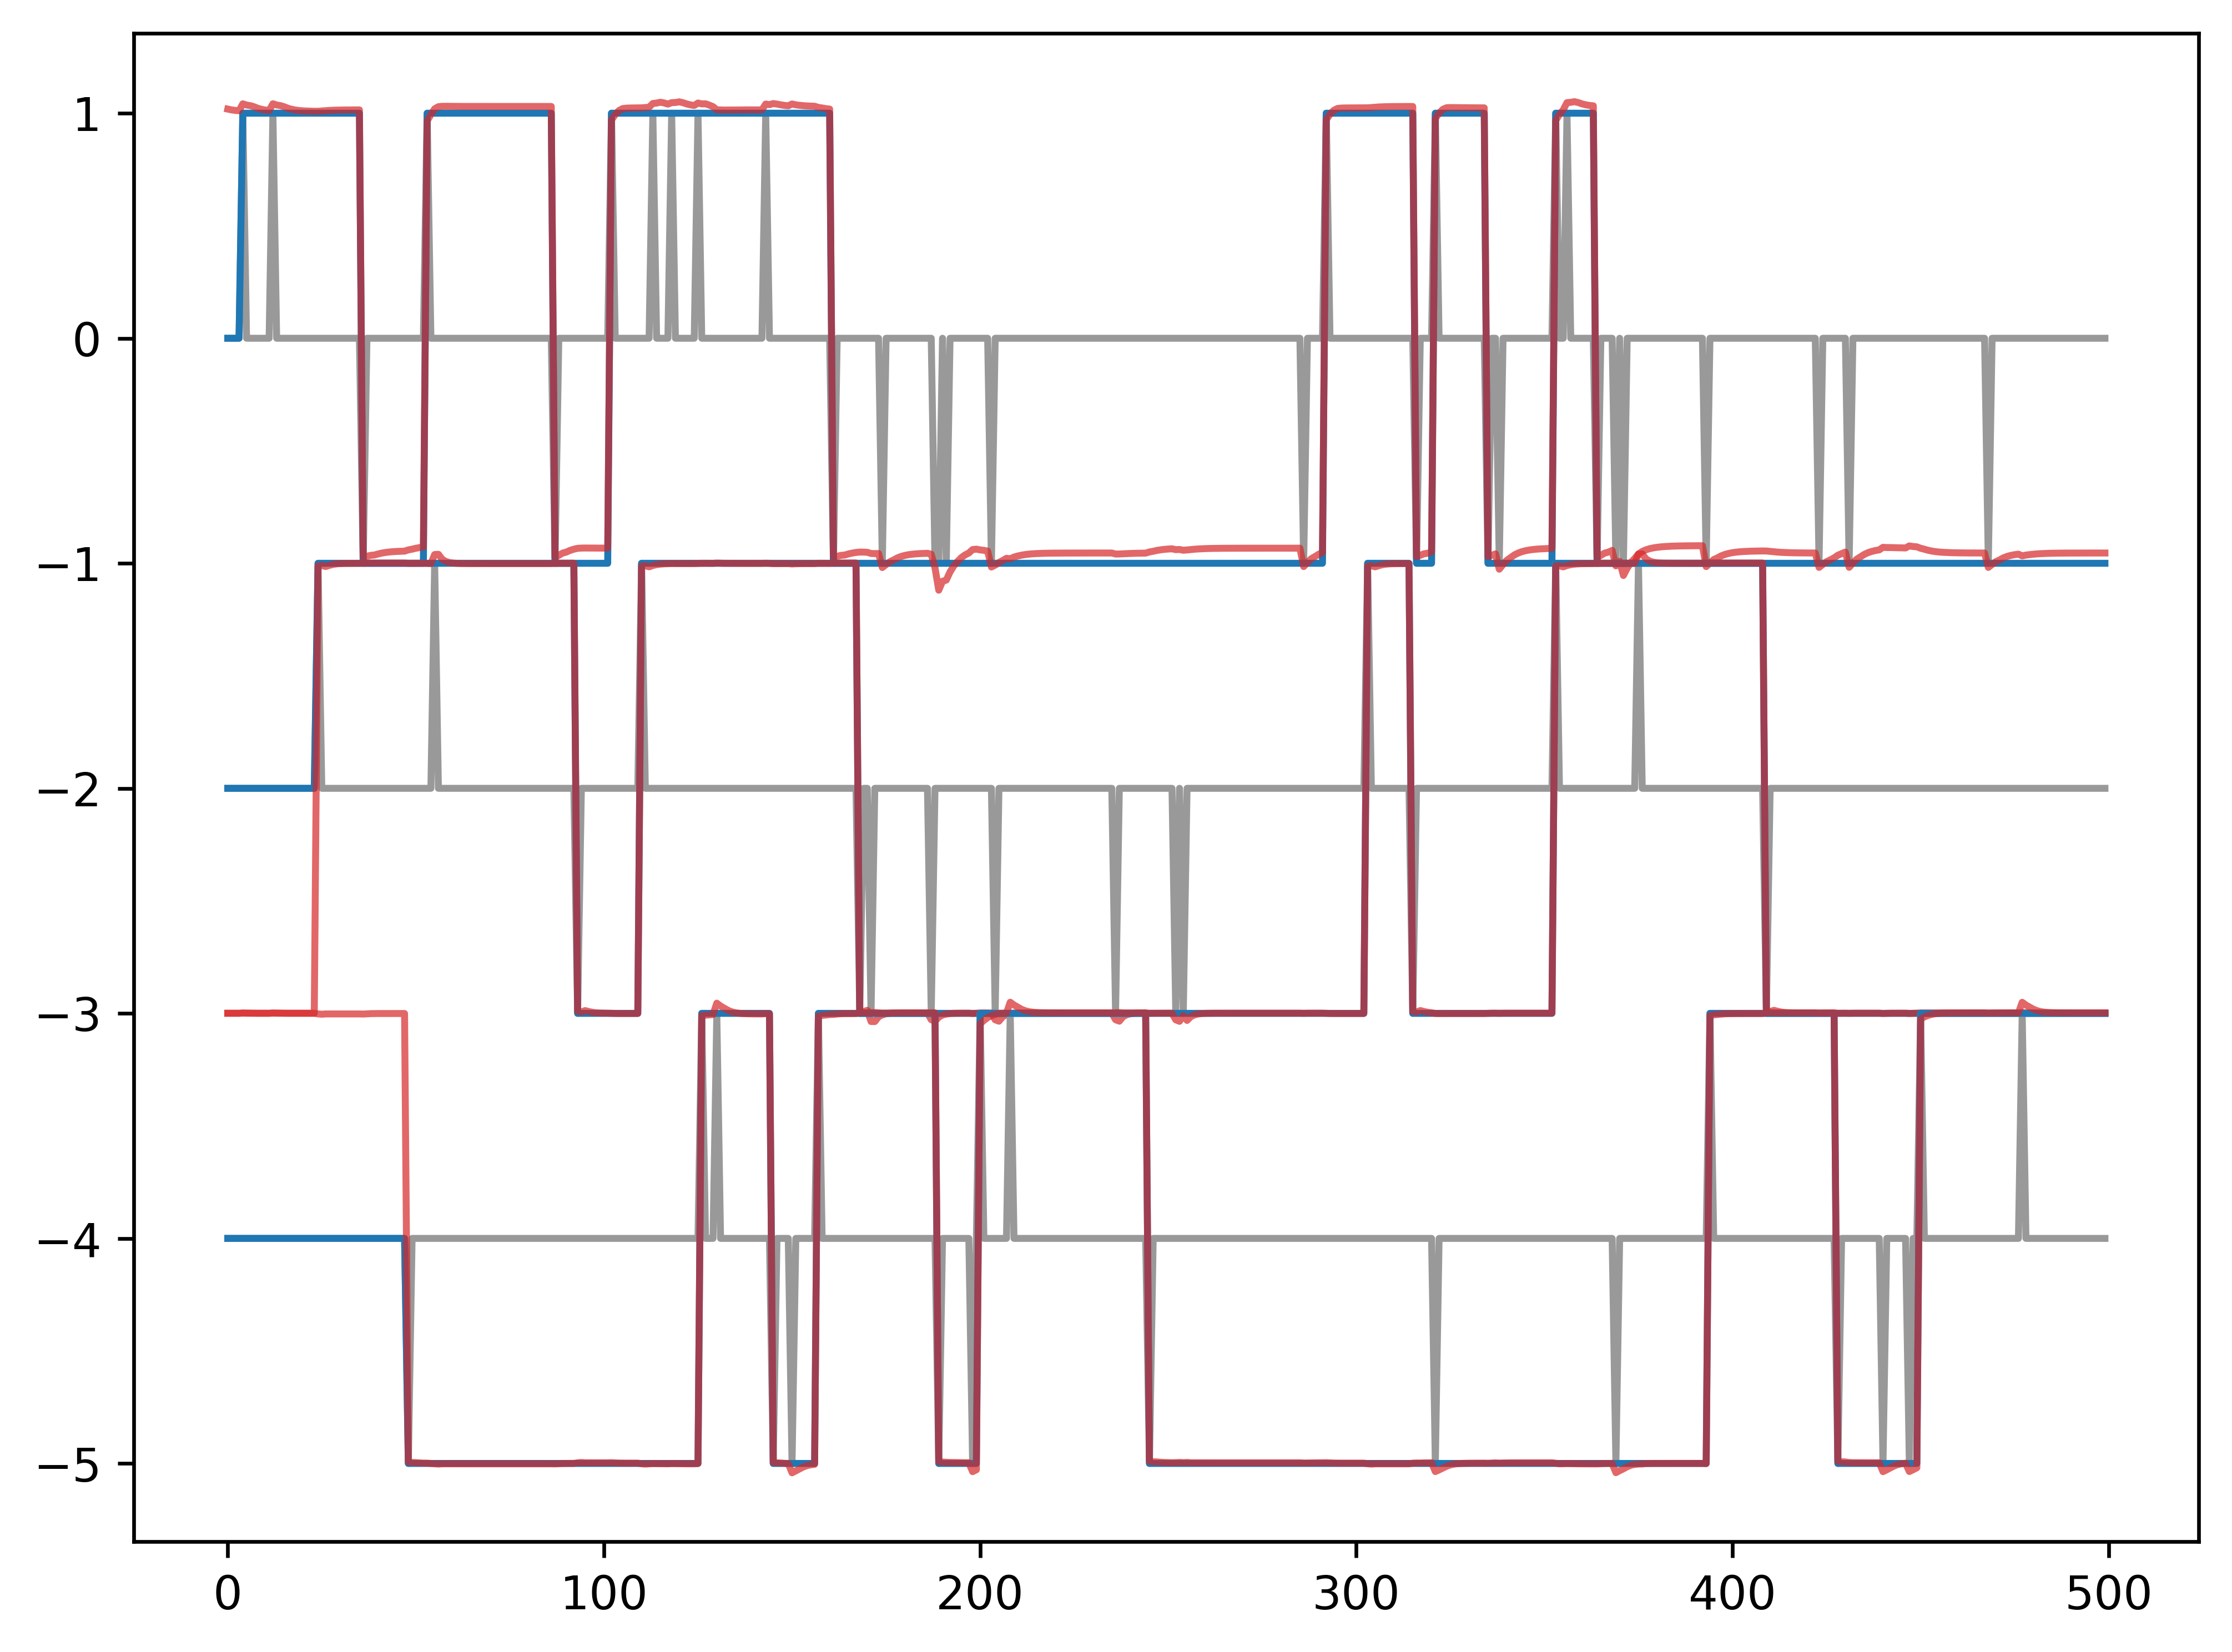

In [13]:
rnn = test_sim.rnn
print(rnn.n_out)
plt.figure(figsize=(8, 6), dpi=600)
for i in range(rnn.n_out):
    plt.plot(data['test']['X'][:500, i] - i * 2, (str(0.6)))
    plt.plot(data['test']['Y'][:500, i] - i * 2, 'C0')
    plt.plot(test_sim.mons['rnn.y_hat'][:500, i] - i * 2, 'C3', alpha=0.7)